In [78]:
import torch
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple

@dataclass
class Configs:
    #...general params:
    WORKDIR : str = './'   
    DEVICE : str = 'cuda:0'
    MULTI_GPU : bool = False

    #...data params:
    DATA : str = None
    DATA_TARGET : str = 'mnist'
    DATA_SOURCE : str = 'noise'
    DIM_INPUT : int = None
    DIM_CONTEXT : int = 0
    VOCAB_SIZE : int = 2
    INPUT_SHAPE : Tuple[float] = field(default_factory = lambda : (1, 28, 28))
    FLAT_IMAGE : bool = True

    # #...model params:
    MODEL : str = 'StateClassifier'
    NUM_LAYERS : int = 3
    DIM_HIDDEN : int = 128  
    DIM_STATE_EMB : int = 128
    DIM_TIME_EMB : int = 16
    DIM_CONTEXT_EMB : int = 0
    STATE_ENCODING_TYPE : str = 'linear'          # None 'linear' 'kolmogorov-arnold'
    TIME_ENCODING_TYPE : str = 'kolmogorov-arnold'      # None 'linear' 'sinusoidal' 'randomfourier' 'kolmogorov-arnold'
    CONTEXT_ENCODING_TYPE : str = None             # None 'linear' 'kolmogorov-arnold'
    DROPOUT : float = 0.1
    ACTIVATION : str = 'ReLU'

    #...training params:
    BATCH_SIZE : int = 128
    DATA_SPLIT_FRACS : List[float] = field(default_factory = lambda : [0.83334, 0.16667, 0.0])  # train / val / test 
    EPOCHS: int = 20
    EARLY_STOPPING : int = None
    MIN_EPOCHS : int = None 
    PRINT_EPOCHS : int = None   
    NUM_WORKERS : int = 0
    PIN_MEMORY: bool = False

    #...cjb params:
    DYNAMICS : str = 'ConditionalJumpBridge'
    GAMMA: float = 0.1

    #...optimization & scheduler params:
    OPTIMIZER: str = 'Adam'
    LR : float = 2e-4
    WEIGHT_DECAY : float = 0.0
    OPTIMIZER_BETAS : List[float] = field(default_factory = lambda : [0.9, 0.999])
    OPTIMIZER_EPS : float = 1e-8
    OPTIMIZER_AMSGRAD : bool = False
    GRADIENT_CLIP : float = None
    SCHEDULER: str = None
    SCHEDULER_T_MAX: int = None
    SCHEDULER_ETA_MIN: float = None
    SCHEDULER_GAMMA: float = None
    SCHEDULER_STEP_SIZE: int = None

    #...generation pipeline params:
    SAMPLER : str = 'TauLeaping'
    NUM_TIMESTEPS : int = 100
    TIME_EPS : float = 1e-3

    def __post_init__(self):
        self.DATA = self.DATA_SOURCE + '_to_' + self.DATA_TARGET
        self.DIM_INPUT = np.prod(self.INPUT_SHAPE)
        if self.MULTI_GPU: self.DEVICE = 'cuda:0'


# Data

In [79]:
from torchvision.transforms import ToPILImage
from cmb.data.binary_mnist import MNISTDataClass
from cmb.data.utils import DefineDataloader

conf = Configs()
mnist = MNISTDataClass(conf)
dataloader = DefineDataloader(mnist)
transform = ToPILImage()

for batch in dataloader.train:
    pair = torch.cat([batch.source[0].view(1, 28,28), batch.target[0].view( 1, 28,28)], dim=1)
    img = transform(pair)
    break

img

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 58333, validation size: 11666, testing sizes: 0


# Train model

In [80]:
from cmb.dynamics.cjb import ConditionalJumpBridge
from cmb.models.architectures.state_classifier import StateClassifier 
from cmb.models.trainers import CMBTrainer

conf = Configs()
mnist = MNISTDataClass(conf)
dynamics = ConditionalJumpBridge(conf)
classifier = StateClassifier(conf)
print(classifier)
generative_model = CMBTrainer(dynamics, classifier, mnist)
generative_model.train()

number of training parameters: 13083728
number of training parameters: 13083728
number of training parameters: 13083728
number of training parameters: 13083728
number of training parameters: 13083728
number of training parameters: 13083728
number of training parameters: 13083728
number of training parameters: 13083728
start training...
start training...
start training...
start training...
start training...
start training...
start training...
start training...


StateClassifier(
  (act_fn): ReLU()
  (state_embedding): Sequential(
    (0): Embedding(2, 128)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=100352, out_features=128, bias=True)
  )
  (time_embedding): Sequential(
    (0): KANLinear(
      (base_activation): SiLU()
    )
    (1): Linear(in_features=16, out_features=16, bias=True)
  )
  (context_embedding): Identity()
  (layers): Sequential(
    (0): Linear(in_features=144, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=128, out_features=1568, bias=True)
  )
)
INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train s

epochs:   0%|          | 0/20 [00:00<?, ?it/s]

# Generate samples

In [81]:
from cmb.dynamics.cjb import ConditionalJumpBridge
from cmb.models.architectures.state_classifier import StateClassifier 
from cmb.models.trainers import CMBTrainer
from cmb.data.binary_mnist import MNISTDataClass

conf = Configs()
mnist = MNISTDataClass(conf)
dynamics = ConditionalJumpBridge(conf)
classifier = StateClassifier(conf)
generative_model = CMBTrainer(dynamics, classifier, mnist)

generative_model.load()

INFO: building dataloaders...
INFO: train/val/test split ratios: 0.83334/0.16667/0.0
INFO: train size: 58333, validation size: 11666, testing sizes: 0


In [82]:
from cmb.models.pipelines import CJBPipeline

conf.GAMMA = .05
conf.NUM_TIMESTEPS = N = 500 #int(1. / conf.GAMMA)
conf.TIME_EPS = 0.0

pipeline = CJBPipeline(trained_model=generative_model, config=conf)
input_source = torch.randint(0, 2, (128, 784))

pipeline.generate_samples(input_source)
sample = pipeline.jumps.view(N, 128, 1, 28, 28).float()
k1 = pipeline.k1.view(128, 1, 28, 28).float()

print('number of timesteps: {}'.format(N))

AssertionError: 

###  generation
state: None

time: sinusoidal encoding

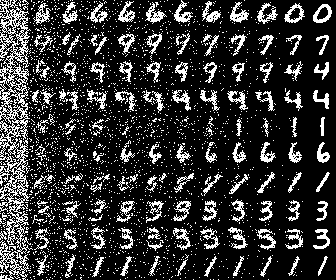

In [74]:
import random

from torchvision.transforms import ToPILImage

transform = ToPILImage()
generated_sample = []

boundary = torch

for idx in random.sample(range(0, 128), 10):
    img = []
    img1 = []
    
    for time_step in range(0, N, N//10):
        img.append(sample[time_step, idx,:,:,:]) 
    img.append(sample[-1, idx,:,:,:]) 
    img.append(k1[idx,:,:,:])
    img = torch.cat(img, dim=-1)
    generated_sample.append(img)

generated_sample = torch.cat(generated_sample, dim=1)
transform(generated_sample)

###  generation
state: linear encoding

time: sinusoidal encoding


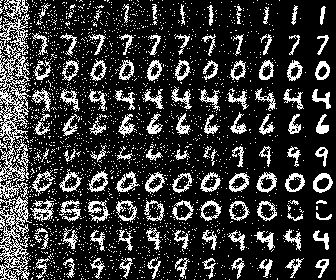

In [63]:
import random

from torchvision.transforms import ToPILImage

transform = ToPILImage()
generated_sample = []

boundary = torch

for idx in random.sample(range(0, 128), 10):
    img = []
    img1 = []
    
    for time_step in range(0, N, N//10):
        img.append(sample[time_step, idx,:,:,:]) 
    img.append(sample[-1, idx,:,:,:]) 
    img.append(k1[idx,:,:,:])
    img = torch.cat(img, dim=-1)
    generated_sample.append(img)

generated_sample = torch.cat(generated_sample, dim=1)
transform(generated_sample)

###  generation
state: linear encoding

time: sinusoidal encoding

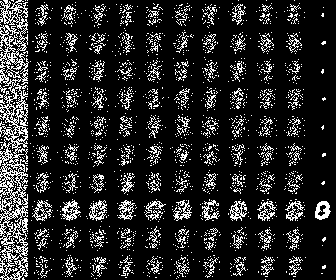

In [6]:
import random

from torchvision.transforms import ToPILImage

transform = ToPILImage()
generated_sample = []

boundary = torch

for idx in random.sample(range(0, 128), 10):
    img = []
    img1 = []
    
    for time_step in range(0, N, N//10):
        img.append(sample[time_step, idx,:,:,:]) 
    img.append(sample[-1, idx,:,:,:]) 
    img.append(k1[idx,:,:,:])
    img = torch.cat(img, dim=-1)
    generated_sample.append(img)

generated_sample = torch.cat(generated_sample, dim=1)
transform(generated_sample)